In [1]:
# https://github.com/facebookresearch/moco

In [2]:
from ds.physio import PhysioNetImageDataset
import warnings, torch, os
import pandas as pd
import torch.utils.data as data
from utils.train import get_dataloader_g, collate_fn
from utils.device import clean_memory_get_device
from utils.plot import plot_train
import math
import numpy as np
from IPython.display import clear_output
from contrastive_learner import ContrastiveLearner
from torchvision import models

pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

In [3]:
device = clean_memory_get_device()

This notebook will running on device: [CUDA]


In [4]:
image_size = 128
batch_size = 128
epochs = 100
train_d = data.DataLoader(
    PhysioNetImageDataset(split_str="train", image_size=image_size),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=None,
    generator=get_dataloader_g(0),
    drop_last=True,
)

In [5]:
resnet = models.resnet18(pretrained=True)

In [6]:
from moco.builder import MoCoSingleGPU

In [7]:
learner = MoCoSingleGPU(
    models.resnet18,
    image_size=image_size,
    # hidden_layer="avgpool",  # layer name where output is hidden dimension. this can also be an integer specifying the index of the child
    dim=512,
)

In [8]:
# import torch.distributed as dist
# learner = torch.nn.parallel.DistributedDataParallel(learner)
# dist.init_process_group(
#             backend=args.dist_backend,
#             init_method=args.dist_url,
#             world_size=args.world_size,
#             rank=args.rank,
#         )

In [9]:
optimizer = torch.optim.AdamW(
    params=[p for p in learner.parameters() if p.requires_grad],
    lr=3e-4,
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=math.ceil(len(train_d.dataset) / batch_size)
    * epochs,  # 286,817 is the size of the training dataset. (https://paperswithcode.com/dataset/cnn-daily-mail-1)
    eta_min=1e-8,
)

In [10]:
def train_one_epoch(
    model,
    optimizer,
    data_loader,
    device,
    epoch,
    max_norm=0,
    lr_scheduler=None,
):
    model.to(device)
    model.train()
    iters = math.ceil(len(data_loader.dataset) / train_d.batch_size)

    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, iters - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    losses = []

    for i, x in enumerate(data_loader):
        loss = model(x.to(device))
        optimizer.zero_grad()
        loss.backward()
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        if lr_scheduler is not None:
            if isinstance(
                lr_scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
            ):
                lr_scheduler.step(epoch + i / iters)
            else:
                lr_scheduler.step()
        losses.append(loss.item())
    return losses

In [11]:
learner.encoder_q

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

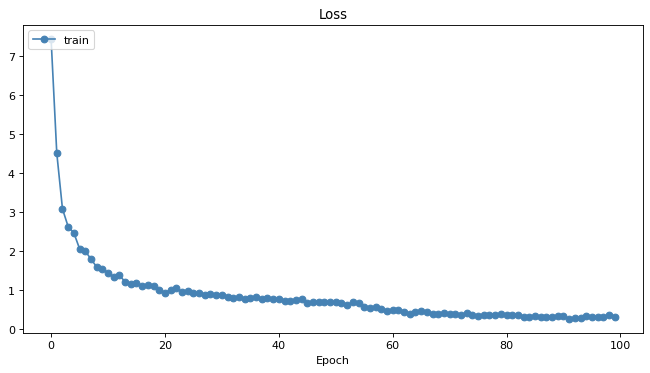

In [12]:
train_losses = []
for epoch in range(epochs):
    train_l = train_one_epoch(
        learner,
        optimizer,
        train_d,
        device,
        epoch,
        max_norm=1,
        lr_scheduler=scheduler,
    )
    train_losses.append(np.mean(train_l))
    clear_output()
    plot_train(train_losses, title="Loss")

In [13]:
model_path = "moco"

saving_dict = {"model": learner.state_dict()}
if optimizer:
    saving_dict["optimizer"] = optimizer.state_dict()

saving_folder = os.path.join("checkpoints", model_path)
os.makedirs("checkpoints", exist_ok=True)
os.makedirs(saving_folder, exist_ok=True)
torch.save(
    saving_dict,
    os.path.join("checkpoints", model_path, "model"),
)

# learner.net.net.state_dict() # resnet here.